<a href="https://colab.research.google.com/github/LAHYANIOmar/Emotion-classificaion/blob/main/projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This sample demonstrates celebrity face classification using Keras with transfer learning

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hamdirazi","key":"008e73530fa055be9cc917988b0cfd2d"}'}

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gaborfodor/keras-pretrained-models
import zipfile
with zipfile.ZipFile('/content/keras-pretrained-models.zip', 'r') as zip_ref:
    zip_ref.extractall('fer2013')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 941M/943M [00:45<00:00, 21.6MB/s]
100% 943M/943M [00:45<00:00, 21.7MB/s]


In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dansbecker/5-celebrity-faces-dataset
import zipfile
with zipfile.ZipFile('/content/5-celebrity-faces-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('5-celebrity-faces-dataset')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
 79% 4.00M/5.03M [00:01<00:00, 4.31MB/s]
100% 5.03M/5.03M [00:01<00:00, 3.78MB/s]


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


data_dir = '/content/5-celebrity-faces-dataset/data'
vgg16weight = '/content/fer2013/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet50weight = '/content/fer2013/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, SGD
from keras import backend as K

import keras

import matplotlib.pyplot as plt

### 1. Prepare Data

In [ ]:
img_width, img_height = 200, 200

train_data_dir = os.path.join(data_dir, 'train')
validation_data_dir = os.path.join(data_dir, 'val')
nb_train_samples = 93
nb_validation_samples = 25
epochs = 50
batch_size = 16
numclasses = 5

In [ ]:
# dataset
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    #shear_range=0.2,
    vertical_flip=False,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 93 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


### 2. Model

In [ ]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [ ]:
def vgg16CNNtl(input_shape, outclass, sigma='sigmoid'):

    base_model = None
    base_model = keras.applications.VGG16(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(vgg16weight)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    for i in range(2):
        top_model.add(Dense(4096, activation='relu'))
        top_model.add(Dropout(0.5))
    top_model.add(Dense(outclass, activation=sigma))

    model = None
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    return model

def resnet50tl(input_shape, outclass, sigma='sigmoid'):

    base_model = None
    base_model = tf.keras.applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(resnet50weight,by_name=True, skip_mismatch=True)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    for i in range(2):
        top_model.add(Dense(4096, activation='relu'))
        top_model.add(Dropout(0.5))
    top_model.add(Dense(outclass, activation=sigma))

    model = None
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    return model


In [ ]:
import tensorflow as tf

In [ ]:
model = resnet50tl(input_shape, numclasses, 'softmax')
lr = 1e-5
decay = 1e-7 #0.0
optimizer = RMSprop(lr=lr, decay=decay)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

ResourceExhaustedError: ignored

### 3. Train

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

<ipython-input-24-50dac1443f25>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50


ResourceExhaustedError: ignored

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
training_acc = history.history['acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig=plt.figure(figsize=(12, 4))
# Visualize loss history
fig.add_subplot(121)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Training Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss/Acc')

# Get training and test loss histories
val_acc = history.history['val_acc']
training_acc = history.history['acc']

# Create count of the number of epochs
epoch_count = range(1, len(val_acc) + 1)

# Visualize loss history
fig.add_subplot(122)
plt.plot(epoch_count, val_acc, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show();

KeyError: ignored

In [ ]:
saveweight =  'celebriytag_weight.h5'
model.save_weights(saveweight)

### 4. Evaluation

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import cv2
import requests
import os

In [ ]:
labels = ['ben_afflek',  'elton_john',  'jerry_seinfeld',  'madonna',  'mindy_kaling']
test_imgs = ['ben_afflek/httpabsolumentgratuitfreefrimagesbenaffleckjpg.jpg']

for test in test_imgs:
    test_img = os.path.join(validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)

    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)

    #print("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))

AttributeError: ignored

In [ ]:
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount('content/')

Mounted at content/


In [ ]:
model1_path = "/content/drive/MyDrive/reco.h5"

# Load the model
model1 = keras.models.load_model(model1_path)

In [ ]:
from tensorflow import keras

# Specify the path to your .h5 model file
model_path = "/content/drive/MyDrive/_mini_XCEPTION.42-0.67.hdf5"

# Load the model
model = keras.models.load_model(model_path)

# Use the loaded model for further operations
# ...


In [ ]:
labels = ['ben_afflek',  'elton_john',  'jerry_seinfeld',  'madonna',  'mindy_kaling']

In [ ]:
import tensorflow as tf
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import cv2
import requests
import os
import cv2

In [ ]:
img_width, img_height = 200, 200


In [ ]:
test_img="/content/123.jpg"
img = cv2.imread(test_img)
img=cv2.resize(img,(img_width,img_height))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
x = np.array(img).astype(float)
x = np.expand_dims(x, axis=0)
x /= 255.

In [ ]:
import numpy as np
labels[np.argmax(model1.predict(x))]

1/1 [==============================] - 8s 8s/step


'jerry_seinfeld'

In [ ]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [ ]:
r=preprocess_input(img)

In [ ]:
r = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
r=cv2.resize(r,(48,48))
r=np.array(r).reshape(1,48,48,1)
np.argmax(model.predict(r))

1/1 [==============================] - 1s 1s/step


0

In [ ]:
model.summary()

Model: "Net50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 46, 46, 8)    80          ['input_1[0][0]']                
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 46, 46, 8)    32          ['conv1[0][0]']                  
                                                                                                  
 activation (Activation)        (None, 46, 46, 8)    0           ['bn_conv1[0][0]']               
                                                                                              

In [ ]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
img=cv2.imread("/content/elton.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img=preprocess_input(img)
img=cv2.resize(img,(48,48))
img=np.array(img).reshape(1,48,48)
img.shape

(1, 48, 48)

In [ ]:
def process_img_emotion(img_path):
  img=cv2.imread("/content/elton.jpg")
  img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img=preprocess_input(img)
  img=cv2.resize(img,(48,48))
  img=np.array(img).reshape(1,48,48)
  return img

In [ ]:
process_img_emotion('/content/elton.jpg')

array([[[-0.85759807, -0.89428616, -0.52323836, ..., -0.8980392 ,
         -0.8980392 , -0.8980392 ],
        [-0.7054764 , -0.76717216,  0.7814262 , ..., -0.8980392 ,
         -0.8980392 , -0.8980392 ],
        [-0.53708637, -0.018053  , -0.33268228, ..., -0.9041667 ,
         -0.8980392 , -0.8980392 ],
        ...,
        [ 0.04554234,  0.12170655,  0.12818632, ...,  0.23055305,
         -0.0633425 ,  0.10446543],
        [ 0.07001384,  0.07083338,  0.14944857, ...,  0.30302545,
          0.06782326, -0.16827512],
        [-0.02107843,  0.08284319,  0.2555684 , ...,  0.08803621,
          0.14339006, -0.10929074]]], dtype=float32)

In [ ]:
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))

In [ ]:
output = model.predict(img)
classes[np.argmax(output)]

1/1 [==============================] - 0s 35ms/step


'Sad'

In [ ]:
labels = ['ben_afflek',  'elton_john',  'jerry_seinfeld',  'madonna',  'mindy_kaling']
img_width, img_height = 200, 200


In [ ]:
test_img="/content/123.jpg"
img1 = cv2.imread(test_img)
img1=cv2.resize(img1,(img_width,img_height))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
x = np.array(img1).astype(float)
x = np.expand_dims(x, axis=0)
x /= 255.

In [ ]:
labels[np.argmax(model1.predict(x))]

1/1 [==============================] - 0s 23ms/step


'jerry_seinfeld'

In [ ]:
def process_img_recognition(img_path):
  img_width, img_height = 200, 200
  img1 = cv2.imread(img_path)
  img1=cv2.resize(img1,(img_width,img_height))
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  x = np.array(img1).astype(float)
  x = np.expand_dims(x, axis=0)
  x /= 255.
  return x

In [ ]:
def process_img_emotion(img_path):
  img=cv2.imread(img_path)
  img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img=preprocess_input(img)
  img=cv2.resize(img,(48,48))
  img=np.array(img).reshape(1,48,48)
  return img

In [ ]:
def result(img_path):
  classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
  labels = ['ben_afflek',  'elton_john',  'jerry_seinfeld',  'madonna',  'mindy_kaling']
  img=process_img_emotion(img_path)
  img1=process_img_recognition(img_path)
  result_recognition=labels[np.argmax(model1.predict(img1))]
  result_emotion=classes[np.argmax(model.predict(img))]
  image=cv2.imread(img_path)
  plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
  print('The Celebrity {} is {}'.format(result_recognition,result_emotion))

1/1 [==============================] - 0s 25ms/step
The Celebrity ben_afflek is Sad


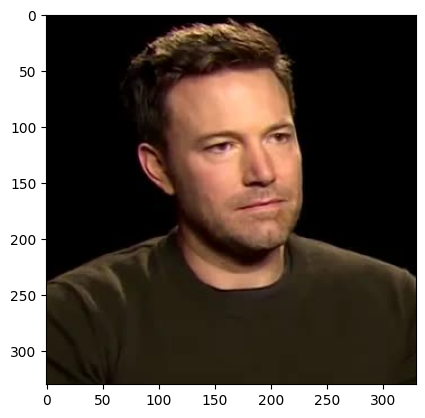

In [ ]:
result('/content/benaffleck.jpg')

1/1 [==============================] - 0s 134ms/step
The Celebrity madonna is Happy


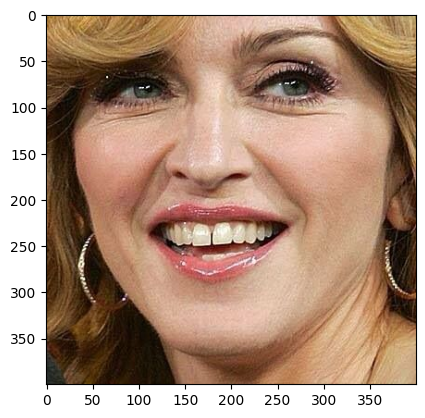

In [ ]:
result('/content/1234.jpg')

1/1 [==============================] - 0s 52ms/step
The Celebrity ben_afflek is Neutral


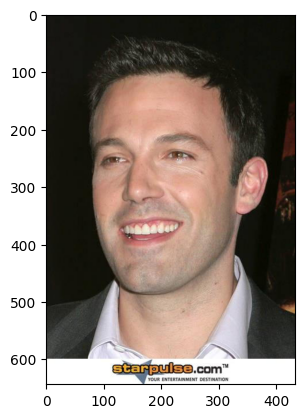

In [ ]:
result('/content/45.jpg')